## This notebook uses the relations in Chaplin et al. 2011 to prediction the detection probability of stars a s function of Kepler magnitude.

In [1]:
import numpy as np
import scipy.stats as stats
from matplotlib.pyplot import *

In [2]:
def env_width(numax):
    if numax <= 100:
        return 1.32*numax**0.88
    else:
        return numax
    
def getRadius(Teff, L, C):
    return L**0.5 * (Teff/C['Teff0'])**-2

def getSeismicParameters(Teff, R, C):
    
    numax = C['numax0'] * R**-1.85 * (Teff/C['Teff0'])**0.92 # from (14) # mass-less scaling relation
    dnu   = C['dnu0']   * R**-1.42 * (Teff/C['Teff0'])**0.71
    return dnu, numax

In [3]:
def granulation(nu0, dilution, a_nomass, b1, b2, vnyq):
    zeta = 2*np.sqrt(2)/np.pi
    eta = np.sinc(nu0/(2*vnyq))
    H1 = 1/b1 / (1 + (nu0/b1)**4)
    H2 = 1/b2 / (1 + (nu0/b2)**4)
    return zeta * a_nomass**2 / dilution**2 * eta**2 * (H1 + H2) 

def totalGranulation(numax, vnyq, dilution=1):

    factor = 1 # set to 1 for Kepler, 0.85 for TESS
    a_nomass = factor * 3382*numax**-0.609 
    b1 = 0.317 * numax**0.970
    b2 = 0.948 * numax**0.992
    
    Pgran = granulation(numax, dilution, a_nomass, b1, b2, vnyq) #2*np.sqrt(2)/np.pi * a_nomass**2 / dilution**2 * np.sinc(nu0/(2*vnyq))**2 * (1/b1 / (1 + (nu0/b1)**4) + 1/b2 / (1 + (nu0/b2)**4)) 

    if numax > vnyq:
        Pgranalias = granulation(vnyq-(numax-vnyq), dilution, a_nomass, b1, b2, vnyq)

    elif numax < vnyq:
        Pgranalias = granulation(vnyq+(vnyq-numax), dilution, a_nomass, b1, b2, vnyq)


    return Pgran + Pgranalias

In [4]:
def totalEnvelope(numax, dnu,  teff, L, R, vnyq, dilution=1, factor=1):
    """
    factor : float
        Scaling factor between Kepler and TESS. 1 for Kepler, 0.85 for TESS, probably 1 for PLATO. 
    """
    teffred = 8907*(L**-0.093)
    
    beta = 1.0-np.exp(-(teffred-teff)/1550)
    
    eta = np.sinc(numax/(2*vnyq))
    
    W = env_width(numax)
    
    c = 2.94
    
    Amax = factor * 2.5 * beta * R**2 * np.sqrt(teff/5777)
    
    ptot = 0.5 * c  * eta**2 * dilution**-2 * W / dnu * Amax**2

    return ptot

In [17]:
#def sigscale(tgtV, tgtTeff, tgtSig, dt = 3600):
#    return tgtSig / np.sqrt(pshot(tgtV, tgtTeff, A=1)/(2e-6*dt))

# def instrumental(mag, cadence, A=1):
#     """
#     a : float
#         For Kepler this should be 1 at 58.85 second cadence. 
        
#         For PLATO this scaling is 2.295, such that 
        
#         sqrt(A*Binstr*1e6/3600) = 50ppm sqrt(hr) 
        
#         at mag=11 at a cadence of 25 seconds. 
        
#     """
    
#     KmagVmagOffset = -0.1

#     kmag = mag+KmagVmagOffset

#     c = 1.28*10**(0.4*(12-kmag)+7) # scaling for Kepler
    
#     sigma = 1e6/c * np.sqrt(c + 9.5e5 * (14/kmag)**5)  # scaling for Kepler
    
#     Binstr = A * 2e-6 * sigma**2 * cadence # units are ppm**2/muHz
    
#     return Binstr


def pshot(V, Teff):
    return 2.00*(32.0/24.0)*Teff/6000.0*2.0*2.86*10**(-0.4*(11.0-V))

def globalDetections(cadence, Vmag, R, L, Teff, numax, dnu, T, C, fap, dilution=1, vary_beta=False):
    
    vnyq = 1/(2*cadence) * 10**6 # in micro Hz

    eta = np.sinc(numax/(2*vnyq))
    
    # Granulation
    Pgrantotal = totalGranulation(numax, vnyq) 
      
    # Envelope power under envelope
    ptot = totalEnvelope(numax, dnu, Teff, L, R, vnyq, dilution=1)

    # Instrumental
    Binstr=  1.226 * pshot(Vmag, Teff) # 1.226 to scale the RMS noise to 50 ppm sqrt(hr)
    
    # Background under envelope
    bgtot = (Binstr + Pgrantotal) * numax # units are ppm**2

    # SNR under envelope
    snr = ptot/bgtot # global signal to noise ratio from (11)
        
    tlen = T*86400.0 # Length of observations in seconds
    
    bin_width= 1e6 / tlen
    
    nbins = int((env_width(numax)*tlen/1e6))
    
    dof = 2*nbins
    
    snrthresh = stats.chi2.ppf(1.0 - fap, dof) / dof - 1
        
    pfinal = stats.chi2.sf((snrthresh+1) / (snr+1) * dof, dof)
    
    return pfinal

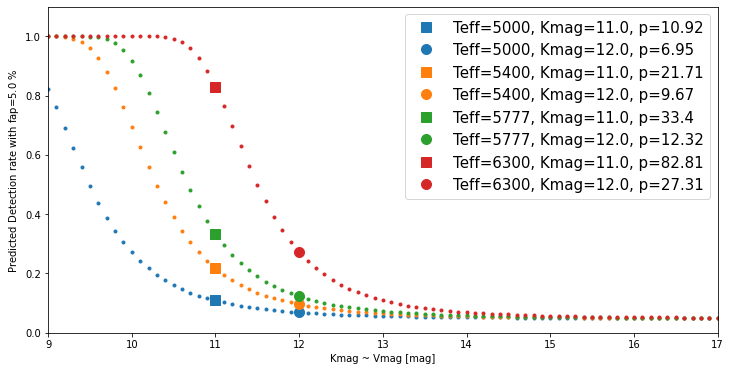

In [21]:

C = {'Teff0': 5777, 'numax0': 3050, 'dnu0': 135.1, 'Teff0Red': 8907}

T = 2*365

cadence = 25 # Kepler cadence (s)

fig, ax = subplots(figsize = (12,6))

cols = ['C0', 'C1', 'C2', 'C3']

shap = ['s', 'o']

L    = [0.31564076, 0.6183731,   1., 2.39022857]

Teff = [5000      , 5400     , 5777, 6300]

fap = 0.05

for i in range(len(Teff)):
    
    R =  getRadius(Teff[i], L[i], C)# Steffan-Boltzmann law
    
    dnu, numax = getSeismicParameters(Teff[i], R, C)
    
    for kmag in np.linspace(9, 17, 10*8+1):
        
        p = globalDetections(cadence, kmag, R, L[i], Teff[i], numax, dnu, T, C, fap, dilution=1, vary_beta=False)
        
        ax.plot(kmag, p, '.', color = cols[i])
        
        if kmag in [11, 12]:
            ax.plot(kmag, p, shap[int(kmag)-11], ms = 10, color = cols[i], label = f'Teff={Teff[i]}, Kmag={kmag}, p={np.round(p*100, 2)}')
        
ax.legend(fontsize = 15)
ax.set_ylim(0,1.1)
ax.set_xlim(9,17)
ax.set_ylabel(f'Predicted Detection rate with fap={np.round(fap*100,3)} $\\%$')
ax.set_xlabel('Kmag ~ Vmag [mag]')
fig.savefig('Predicted_detection_probability.png')

In [ ]:
teff=5800.0 # eff temp

v=9.0 # v mag

dt=3600.0 # 1 hour

#--PLATO prediction for shot PSD
# 2.45 == end of mission precision, 2.00 == beginning of mission
pshotPLATO=2.00*(32.0/24.0)*teff/6000.0*2.0*2.86*10**(-0.4*(11.0-v))

#--Now convert pshotPLATO to RMS noise per root hour
# Follow from: pshotPLATO=2.0*sigPLATO^2*dt*1.0d-06
sigPLATO=np.sqrt((pshotPLATO*1e6)/(2.0*dt))

# Now for Kepler prediction of RMS noise per 60-sec (SC) integration:
c = 1.28*10**(0.4*(12-v)+7)
sigKepler = 1e6/c * np.sqrt(c + 9.5e5 * (14/v)**5)/np.sqrt(60.0) #ppm / sqrt(s)

# And Kepler PSD:
pshotKepler=2.0*sigKepler**2*dt*1e-6

print(sigPLATO/sigKepler)
print(pshotPLATO/pshotKepler)